In [1]:
from collections import defaultdict
import csv
from tqdm import tqdm


## Data Process

In [2]:
def readCSV(path):
    f = open(path, 'rt',encoding='UTF-8')
    c = csv.reader(f)
    header = next(c)
    for l in c:
        d = dict(zip(header,l))
        yield d

In [3]:
def get_feature(path):
    recipe_dict = {}
    for d in tqdm(readCSV(path)):
        recipe_dict[d['id']]= d
    return recipe_dict

In [4]:
import pandas as pd
import numpy as np

r_recipes = pd.read_csv('data/RAW_recipes.csv')
p_recipes = pd.read_csv('data/PP_recipes.csv')

In [5]:
# Using Glove Embeddings

In [6]:
from GetVectorFromGlove import GloveModel

raw_recipe_dict = get_feature("data/RAW_recipes.csv")
raw_feature_list = []
missing = 0
for i in p_recipes.id:
    raw_feature_list.append(raw_recipe_dict[str(i)])

# train_size = int(0.8 * len(p_recipes))
train_size = 1000

train_raw_feature_list = raw_feature_list[:train_size]
calorie_level_train = p_recipes.calorie_level[:train_size]
# test_raw_feature_list = raw_feature_list[train_size:]
# calorie_level_test = p_recipes.calorie_level[train_size:]

test_raw_feature_list = raw_feature_list[train_size:1200]
calorie_level_test = p_recipes.calorie_level[train_size:1200]

231637it [00:06, 37576.92it/s]


In [7]:
GM = GloveModel('.\glove.840B.300d.txt')

def update_words_set(words_count, word_list):
    for word in word_list:
        words_count[word] += 1
 
def get_average_vec_from_word_list_list(word_list_list, words_count):
    words_list = []
    
    for ingre in word_list_list:
        words_list.extend(ingre.split(' '))
    update_words_set(words_count, words_list)
    average_word_vector = GM.get_average_vector_of_word_list(words_list)
    return average_word_vector

In [8]:
# Ingredients with Glove

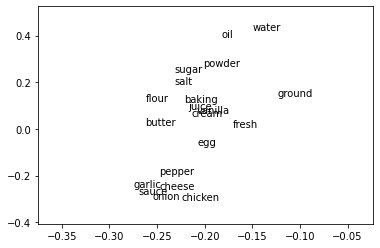

In [9]:
ingredients_words_count = defaultdict(int)

ingredient_vec_train = []
ingredient_vec_test = []
for raw_feature in train_raw_feature_list:
    ingredient_vec_train.append(get_average_vec_from_word_list_list(eval(raw_feature['ingredients']), ingredients_words_count))
for raw_feature in test_raw_feature_list:
    ingredient_vec_test.append(get_average_vec_from_word_list_list(eval(raw_feature['ingredients']), ingredients_words_count))

topk_freq_words = []
for k, v in ingredients_words_count.items():
    topk_freq_words.append((k,v))
topk_freq_words.sort(key=lambda x:x[1], reverse=True)
topk_freq_words = [t[0] for t in topk_freq_words]
GM.get_graph_of_a_word_list(list(topk_freq_words[:20]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          382200    
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 300)               180300    
                                                                 
 dense_1 (Dense)             (None, 3)                 903       
                                                                 
Total params: 2,005,803
Trainable params: 1,623,603
Non-trainable params: 382,200
_________________________________________________________________
Epoch 1/10
4/4 - 14s - loss: 1.1367 - accuracy: 0.4500 - _f1_m: 1.8111 - val_loss: 1.1243 - val_accuracy: 

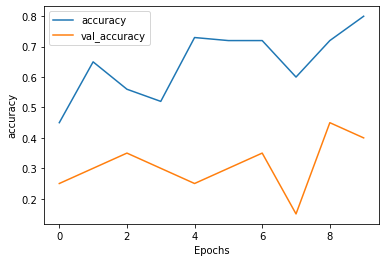

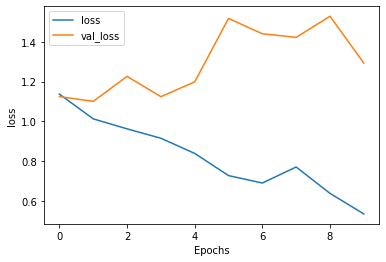

In [10]:
# Steps with Glove and LSTM
from LSTMClassifier import StepsClassifier

steps_articel_train = []
steps_articel_test = []
for raw_feature in train_raw_feature_list:
    steps_articel_train.append(' '.join(eval(raw_feature['steps'])))
for raw_feature in test_raw_feature_list:
    steps_articel_test.append(' '.join(eval(raw_feature['steps'])))

SC = StepsClassifier(steps_articel_train, calorie_level_train, steps_articel_test, calorie_level_test)
SC.train(num_epochs=10)

In [28]:
from tqdm import tqdm

accuracy, f1 = SC.evaluate_model()
print('[Evaluation] Accuracy: ', accuracy, ' F1: ', f1)
print(SC.prediction(steps_articel_train[1]))
labels = ['0', '1', '2']
res_list = []
for s in tqdm(steps_articel_test):
    pred = SC._predict_single(s)
    res_list.append(labels[np.argmax(pred)])
acc = 0
for i in range(len(calorie_level_test)):
    if int(list(calorie_level_test)[i]) == int(res_list[i]):
        acc += 1
print(acc, len(calorie_level_test))
# print(calorie_level_test)
# print(res_list)


1/1 [==============================] - 0s 203ms/step - loss: 1.2930 - accuracy: 0.4000 - _f1_m: 1.0345
[Evaluation] Accuracy:  0.4000000059604645  F1:  1.0344825983047485
414


100%|██████████| 20/20 [00:02<00:00,  8.13it/s]

8 20
